Dans ce notebook vous trouverez de quoi charger les données de test qui vous sont fournies. Voici l'ordre des classes adopté : 

0. Chat
1. Lynx
2. Loup
3. Coyote
4. Jaguar
5. Guépard
6. Chimpanzé
7. Orang-Outan
8. Hamster
9. Cochon d'Inde
10. background

In [1]:
!git clone https://github.com/axelcarlier/testprojet.git

Cloning into 'testprojet'...


In [1]:
def class2num(c):
    id = -1
    if (c=='Chat'):
        id = 0
    elif (c=='Lynx'):
        id = 1
    elif (c=='Loup'):
        id = 2
    elif (c=='Coyote'):
        id = 3
    elif (c=='Jaguar'):
        id = 4
    elif (c=='Guépard'):
        id = 5
    elif (c=='Chimpanzé'):
        id = 6
    elif (c=='Orang-Outan'):
        id = 7
    elif (c=='Hamster'):
        id = 8
    elif (c=='Cochon d\'Inde'):
        id = 9
    else:
        print('Classe inconnue')
        
    return id
        
    

In [2]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# Segmentation d'objet

In [3]:
import pylab as plt
import numpy as np
from matplotlib.path import Path

def create_mask(poly):

    width, height=64, 64

    #polygon=[(0.1*width, 0.1*height), (0.15*width, 0.7*height), (0.8*width, 0.75*height), (0.72*width, 0.15*height)]
    poly_path=Path(poly)

    x, y = np.mgrid[:height, :width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

    mask = poly_path.contains_points(coors)
    
    mask = np.transpose(mask.reshape(height, width))
    #plt.imshow(mask.reshape(height, width))
    #plt.show()
    
    return mask


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json


images = np.zeros((100, 64, 64, 3))
masks = np.zeros((100, 64, 64))

index_img = 0
for file in range(10):
    start_image = file*10+1
    end_image = (file+1)*10
    
    json_file = 'annotations' + str(start_image) + '-' + str(end_image) + '.json'
    with open('testprojet/annotations/segmentation/' + json_file, 'r') as f:      
        data = json.load(f)
        
        for i in range(len(data['images'])):
            
            new_mask = 10*np.ones((64,64))
            
            data_img = data['images'][i]
            img_name = data_img['image']
            img = cv2.imread('testprojet/test/' + img_name)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #plt.imshow(RGB_img)
            #plt.show()
            polygon_annotations = data_img['annotations'][0]['annotations']
            
            for m in range(len(polygon_annotations)):
                obj_class = polygon_annotations[m]['classId']
                mask = create_mask(np.array(polygon_annotations[m]['annotation']))
                new_mask[mask] = obj_class-1
                
            #plt.imshow(new_mask)
            #plt.show()
            
            
            images[index_img] = RGB_img
            masks[index_img] = new_mask
            index_img += 1

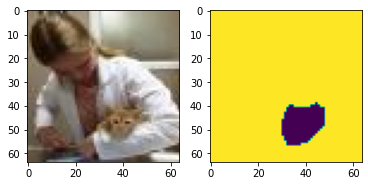

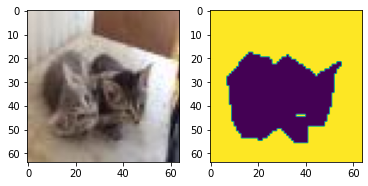

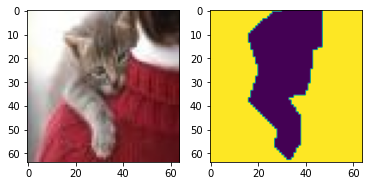

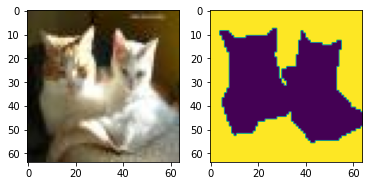

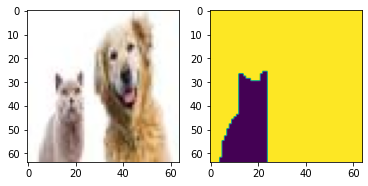

In [5]:
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(images[i].astype('uint8'))
    plt.subplot(1,2,2)
    plt.imshow(masks[i])
    plt.show()

In [6]:
images.shape,masks.shape

((100, 64, 64, 3), (100, 64, 64))

In [7]:
y_test = np.zeros((100, 64, 64, 11))

for i in range(masks.shape[0]):
    for c in range(11):
        y_test[i, :, :, c] = np.where(masks[i]==c, 1, 0)

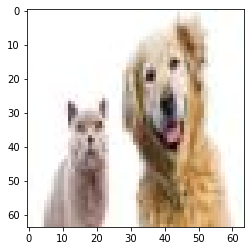

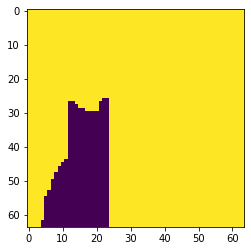

In [8]:
index = 4
plt.figure()
plt.imshow(images[index,:,:,:].astype('uint8'))
plt.figure()
plt.imshow(y_test[index,:,:,10])

In [9]:
from utils.dataloader import *

x,y = load_data()
print(x.shape,y.shape)

(311, 64, 64, 3) (311, 64, 64, 11)


In [10]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.1,random_state=123)

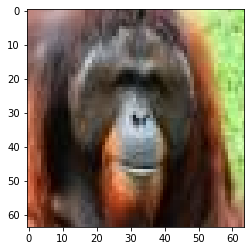

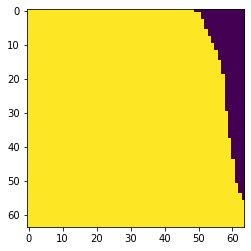

In [13]:
index = 0
plt.figure()
plt.imshow(x_train[index,:,:,:].astype('uint8'))
plt.figure()
plt.imshow(y_train[index,:,:,7])

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import UpSampling2D, concatenate
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, Input, Activation, BatchNormalization, PReLU
from keras.models import Model, Sequential
from keras.initializers import Constant

def create_unet(image_size=64):
  input_layer=Input((image_size, image_size, 3))

  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(11, 1, activation = 'softmax')(conv9)


  model = Model(input_layer, conv10)

  return model

In [15]:
model = create_unet(image_size=64)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [16]:
model = create_unet(image_size=64)

# On utilise Adam, un optimiseur simple, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = keras.optimizers.Adam(learning_rate=3e-4) 

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics='accuracy')

history = model.fit(x/255, y,
          epochs=100,
          batch_size=32,validation_data=(images/255,y_test))

Epoch 1/100
10/10 [==============================] - 7s 259ms/step - loss: 1.9882 - accuracy: 0.3876 - val_loss: 1.9157 - val_accuracy: 0.6064
Epoch 2/100
10/10 [==============================] - 0s 50ms/step - loss: 1.6265 - accuracy: 0.5277 - val_loss: 1.8235 - val_accuracy: 0.6247
Epoch 3/100
10/10 [==============================] - 0s 49ms/step - loss: 1.4587 - accuracy: 0.5478 - val_loss: 1.8223 - val_accuracy: 0.6069
Epoch 4/100
10/10 [==============================] - 0s 49ms/step - loss: 1.3890 - accuracy: 0.5444 - val_loss: 1.8700 - val_accuracy: 0.6211
Epoch 5/100
10/10 [==============================] - 0s 49ms/step - loss: 1.3251 - accuracy: 0.5651 - val_loss: 1.8352 - val_accuracy: 0.6202
Epoch 6/100
10/10 [==============================] - 0s 50ms/step - loss: 1.2915 - accuracy: 0.5700 - val_loss: 1.8191 - val_accuracy: 0.6255
Epoch 7/100
10/10 [==============================] - 0s 50ms/step - loss: 1.2132 - accuracy: 0.5865 - val_loss: 1.8718 - val_accuracy: 0.6239
Epoch

In [48]:
y_test[0,:,:,:10].shape

(64, 64, 10)

In [54]:
y_test[0,:,:,:10].shape

(64, 64, 10)

In [53]:
np.argmax(y_test[0,:,:,:10],2).shape

(64, 64)

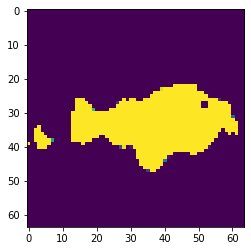

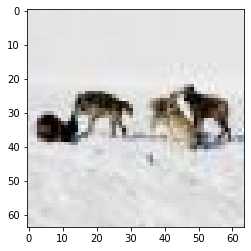

In [75]:
ind_img = 29

prediction = model.predict(np.expand_dims(images[ind_img], axis=0))
ind = 2
plt.imshow(prediction[0,:,:,ind])
plt.show()
plt.imshow(images[ind_img].astype('uint8'))
plt.show()

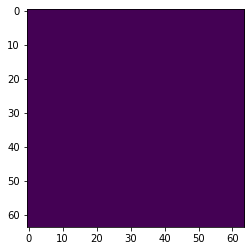

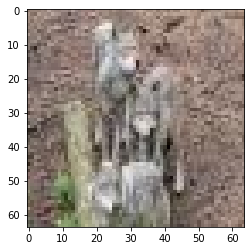

In [49]:
ind_img = 23

prediction = model.predict(np.expand_dims(images[ind_img], axis=0))
ind = np.argmax(y_test[0,:,:,:10],2)[0,0]
plt.imshow(prediction[0,:,:,ind])
plt.show()
plt.imshow(images[ind_img].astype('uint8'))
plt.show()

In [30]:
y_pred = model.predict(x_train[0:1,:,:,:]/255)

In [ ]:
plt.imshow(y_pred[0,:,:,2])

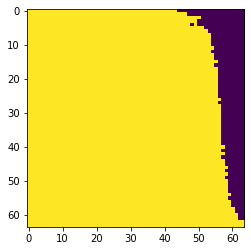

In [53]:
plt.imshow(y_pred[0,:,:,9])